# QA 数据查看器

用于查看和检查 QA 数据集，包括图片、问题、答案和模型回答


In [2]:
import json
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')


In [3]:
json_file_path = "/home/zenglingfeng/qa_pipline12-7/output/测试问题.jsonl"
# 也支持 JSONL 格式：
#json_file_path = "/home/zenglingfeng/qa_pipline/output/测试.jsonl"

# 根据文件扩展名自动判断格式
if json_file_path.lower().endswith('.jsonl'):
    # JSONL 格式：逐行读取
    data = []
    with open(json_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                try:
                    item = json.loads(line)
                    data.append(item)
                except json.JSONDecodeError as e:
                    print(f"⚠️ 警告：跳过无效行: {e}")
    print(f"从 JSONL 文件加载了 {len(data)} 个问题")
else:
    # JSON 格式：标准读取
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # 处理不同的 JSON 结构
    if isinstance(data, dict) and "items" in data:
        data = data["items"]
    elif not isinstance(data, list):
        raise ValueError("输入 JSON 格式不正确，期望数组或包含 'items' 字段的对象")
    print(f"从 JSON 文件加载了 {len(data)} 个问题")


从 JSONL 文件加载了 24 个问题


不需要的字段可以在下面代码里注释

In [4]:
def display_question(item, show_image=True, show_models=True):
    """
    显示单个问题的详细信息（左图右文布局）
    
    参数:
        item: JSON 中的一个问题项
        show_image: 是否显示图片
        show_models: 是否显示模型回答
    """
    from IPython.display import display, HTML
    import base64
    import os
    
    # 收集所有文字信息
    text_lines = []
    
    # 基本信息
    text_lines.append("="*80)
    text_lines.append(f"📝 ID: {item['question_id']}")
    text_lines.append(f"📊 类型: {item['question_type']}")
    text_lines.append(f"🖼️ 图片: {item['image_type']} | ID: {item['image_id']}")
    text_lines.append("="*80)
    text_lines.append("")
    
    # 问题
    text_lines.append("【问题】")
    question = item['question']
    if isinstance(question, dict):
        for round_key, round_question in question.items():
            text_lines.append(f"{round_key}:")
            text_lines.append(f"  {round_question}")
            text_lines.append("")
    else:
        text_lines.append(f"  {question}")
        text_lines.append("")
    
    # 选项
    if item['options']:
        text_lines.append("【选项】")
        for key, value in item['options'].items():
            text_lines.append(f"  {key}: {value}")
        text_lines.append("")
    
    # 标准答案
    text_lines.append("【标准答案】")
    answer = item['answer']
    if isinstance(answer, dict):
        for round_key, round_answer in answer.items():
            text_lines.append(f"  {round_key}: {round_answer}")
    else:
        text_lines.append(f"  {answer}")
    text_lines.append("")
    
    # 出题过程
    if 'qa_make_process' in item:
        text_lines.append("【出题过程】")
        qa_process = item['qa_make_process']
        if isinstance(qa_process, dict):
            for round_key, process in qa_process.items():
                text_lines.append(f"{round_key}:")
                text_lines.append(f"  {process}")
                text_lines.append("")
        else:
            text_lines.append(f"  {qa_process}")
        text_lines.append("")
    
    # 模型回答
    if show_models:
        for model_key in ['model1', 'model2', 'model3']:
            if model_key in item and item[model_key]['enabled']:
                model_data = item[model_key]
                match_status = "✅正确" if model_data['match_gt'] else "❌错误"
                text_lines.append("─"*80)
                text_lines.append(f"🤖 {model_data['model_name'].upper()} {match_status} | 响应: {model_data['response_time']:.2f}秒")
                text_lines.append("")
                '''
                # 模型回答输出（process）
                if 'process' in model_data:
                    text_lines.append("【回答过程】")
                    process = model_data['process']
                    if isinstance(process, dict):
                        for round_key, round_process in process.items():
                            text_lines.append(f"{round_key}:")
                            text_lines.append(f"  {round_process}")
                            text_lines.append("")
                    else:
                        text_lines.append(f"  {process}")
                        text_lines.append("")
                '''
                # 模型答案
                text_lines.append("【最终答案】")
                model_answer = model_data['answer']
                if isinstance(model_answer, dict):
                    for round_key, round_answer in model_answer.items():
                        text_lines.append(f"  {round_key}: {round_answer}")
                else:
                    text_lines.append(f"  {model_answer}")
                text_lines.append("")
                
                # 判断理由
                if 'judge_reasoning' in model_data:
                    text_lines.append(f"【判断理由】{model_data['judge_reasoning']}")
                text_lines.append("")
    
    # 分类信息
    if 'classification' in item:
        classification = item['classification']
        text_lines.append("─"*80)
        text_lines.append(f"📊 级别: {classification['level']} | 类别: {classification['category']} | 一致数: {classification['agreement_count']}")
    
    text_lines.append("="*80)
    
    # 使用HTML实现左图右文布局
    if show_image:
        image_path = item['image_path']
        try:
            # 使用PIL检测真实的图片格式
            from PIL import Image
            with Image.open(image_path) as img:
                img_format = img.format.lower() if img.format else 'png'
                # 标准化格式名称
                if img_format == 'jpg':
                    img_format = 'jpeg'
                elif img_format not in ['png', 'jpeg', 'gif', 'webp']:
                    img_format = 'png'  # 默认使用PNG，因为Clipboard API支持更好
            
            # 将图片转换为base64
            with open(image_path, 'rb') as f:
                img_data = f.read()
                img_base64 = base64.b64encode(img_data).decode()
            
            # 使用检测到的格式，如果检测失败则使用文件扩展名
            img_ext = img_format
            if not img_ext:
                img_ext = image_path.split('.')[-1].lower()
                if img_ext == 'jpg':
                    img_ext = 'jpeg'
                if img_ext not in ['png', 'jpeg', 'gif', 'webp']:
                    img_ext = 'png'  # 默认PNG格式
            
            # 构建HTML - 使用最高清晰度设置，不压缩画质，完整显示图片
            # 获取图片文件名用于下载
            image_filename = os.path.basename(image_path)
            text_content = '\n'.join(text_lines)
            html = f'''
            <div style="display: flex; gap: 20px; align-items: flex-start; width: 100%;">
                <div style="flex: 1; max-width: 50%;">
                    <img src="data:image/{img_ext};base64,{img_base64}" 
                         style="max-width: 100%; width: 100%; height: auto; border: 1px solid #ddd; border-radius: 4px;
                                image-rendering: auto;
                                image-rendering: -webkit-optimize-contrast;
                                -ms-interpolation-mode: bicubic;
                                object-fit: contain;
                                display: block;"
                         onclick="this.style.cursor='pointer';">
                    <div style="margin-top: 10px; text-align: center;">
                        <a href="data:image/{img_ext};base64,{img_base64}" 
                           download="{image_filename}"
                           style="display: inline-block; padding: 8px 16px; background-color: #4CAF50; 
                                  color: white; text-decoration: none; border-radius: 4px; font-size: 14px;
                                  cursor: pointer; transition: background-color 0.3s; margin-right: 10px;"
                           onmouseover="this.style.backgroundColor='#45a049'"
                           onmouseout="this.style.backgroundColor='#4CAF50'">
                            📥 下载原图片
                        </a>
                        <button onclick="
                            (async function() {{
                                try {{
                                    const btn = event.target;
                                    const img = btn.parentElement.previousElementSibling;
                                    const imgSrc = img.src;
                                    
                                    // 创建临时图片元素
                                    const tempImg = new Image();
                                    tempImg.crossOrigin = 'anonymous';
                                    
                                    await new Promise((resolve, reject) => {{
                                        tempImg.onload = resolve;
                                        tempImg.onerror = reject;
                                        tempImg.src = imgSrc;
                                    }});
                                    
                                    // 创建canvas并绘制图片
                                    const canvas = document.createElement('canvas');
                                    canvas.width = tempImg.naturalWidth;
                                    canvas.height = tempImg.naturalHeight;
                                    const ctx = canvas.getContext('2d');
                                    ctx.drawImage(tempImg, 0, 0);
                                    
                                    // 将canvas转换为PNG格式的Blob（PNG格式Clipboard API支持最好）
                                    canvas.toBlob(async (blob) => {{
                                        try {{
                                            await navigator.clipboard.write([
                                                new ClipboardItem({{'image/png': blob}})
                                            ]);
                                            const originalText = btn.innerHTML;
                                            btn.innerHTML = '✅ 已复制!';
                                            btn.style.backgroundColor = '#45a049';
                                            setTimeout(() => {{
                                                btn.innerHTML = originalText;
                                                btn.style.backgroundColor = '#2196F3';
                                            }}, 2000);
                                        }} catch (err) {{
                                            alert('复制失败: ' + err.message);
                                        }}
                                    }}, 'image/png');
                                }} catch (err) {{
                                    alert('复制失败: ' + err.message);
                                }}
                            }})();
                        " 
                        style="display: inline-block; padding: 8px 16px; background-color: #2196F3; 
                               color: white; border: none; border-radius: 4px; font-size: 14px;
                               cursor: pointer; transition: background-color 0.3s;"
                        onmouseover="this.style.backgroundColor='#1976D2'"
                        onmouseout="this.style.backgroundColor='#2196F3'">
                            📋 复制图片
                        </button>
                    </div>
                </div>
                <div style="flex: 1; max-width: 50%; overflow-y: auto; max-height: 800px;">
                    <pre style="font-size: 12px; line-height: 1.4; white-space: pre-wrap; 
                                word-wrap: break-word; font-family: monospace; margin: 0;">{text_content}</pre>
                </div>
            </div>
            '''
            display(HTML(html))
            
        except Exception as e:
            print(f"❌ 无法加载图片: {image_path} | 错误: {e}")
            print('\n'.join(text_lines))
    else:
        # 不显示图片时，直接打印文字
        print('\n'.join(text_lines))


### 使用方式

在下面的代码块中，可以选择不同的查看方式：
- `mode='single'`: 查看指定索引的问题
- `mode='sequential'`: 顺序查看前N个问题
- `mode='random'`: 随机查看N个问题
- `mode='filter'`: 筛选特定类型的问题




################################################################################
# 第 1 个问题（索引: 0）
################################################################################




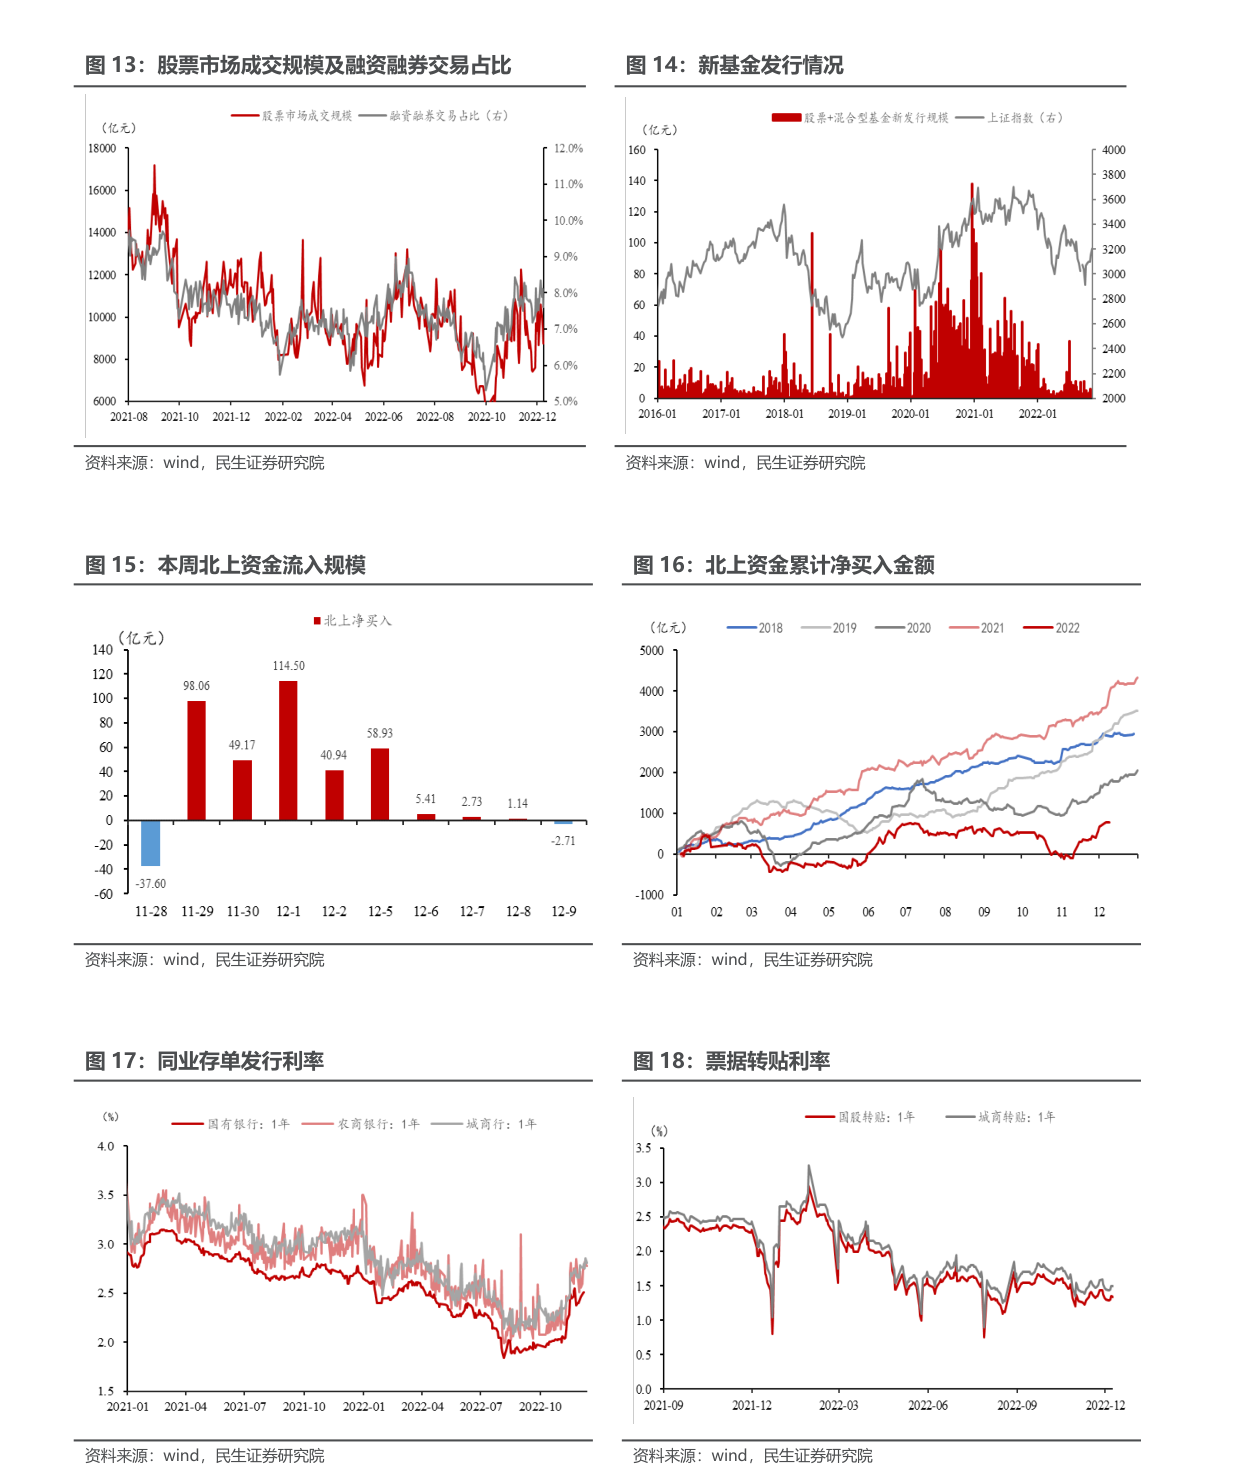
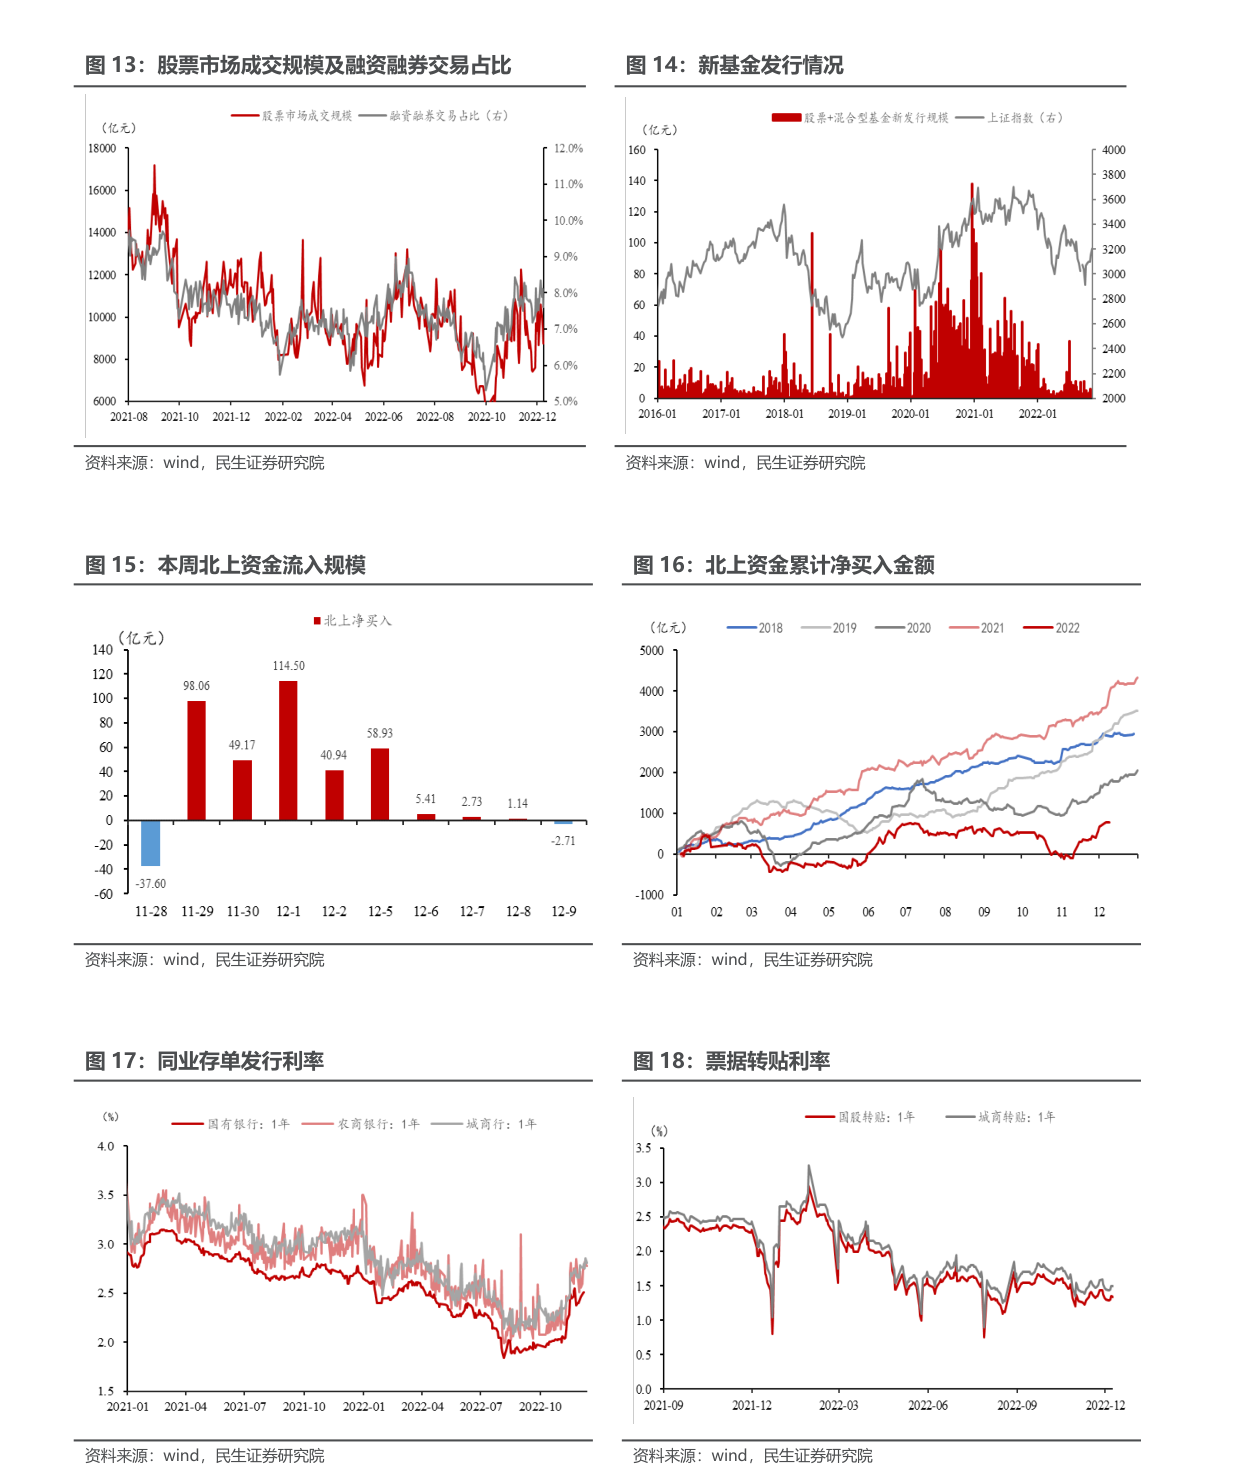



################################################################################
# 第 2 个问题（索引: 1）
################################################################################




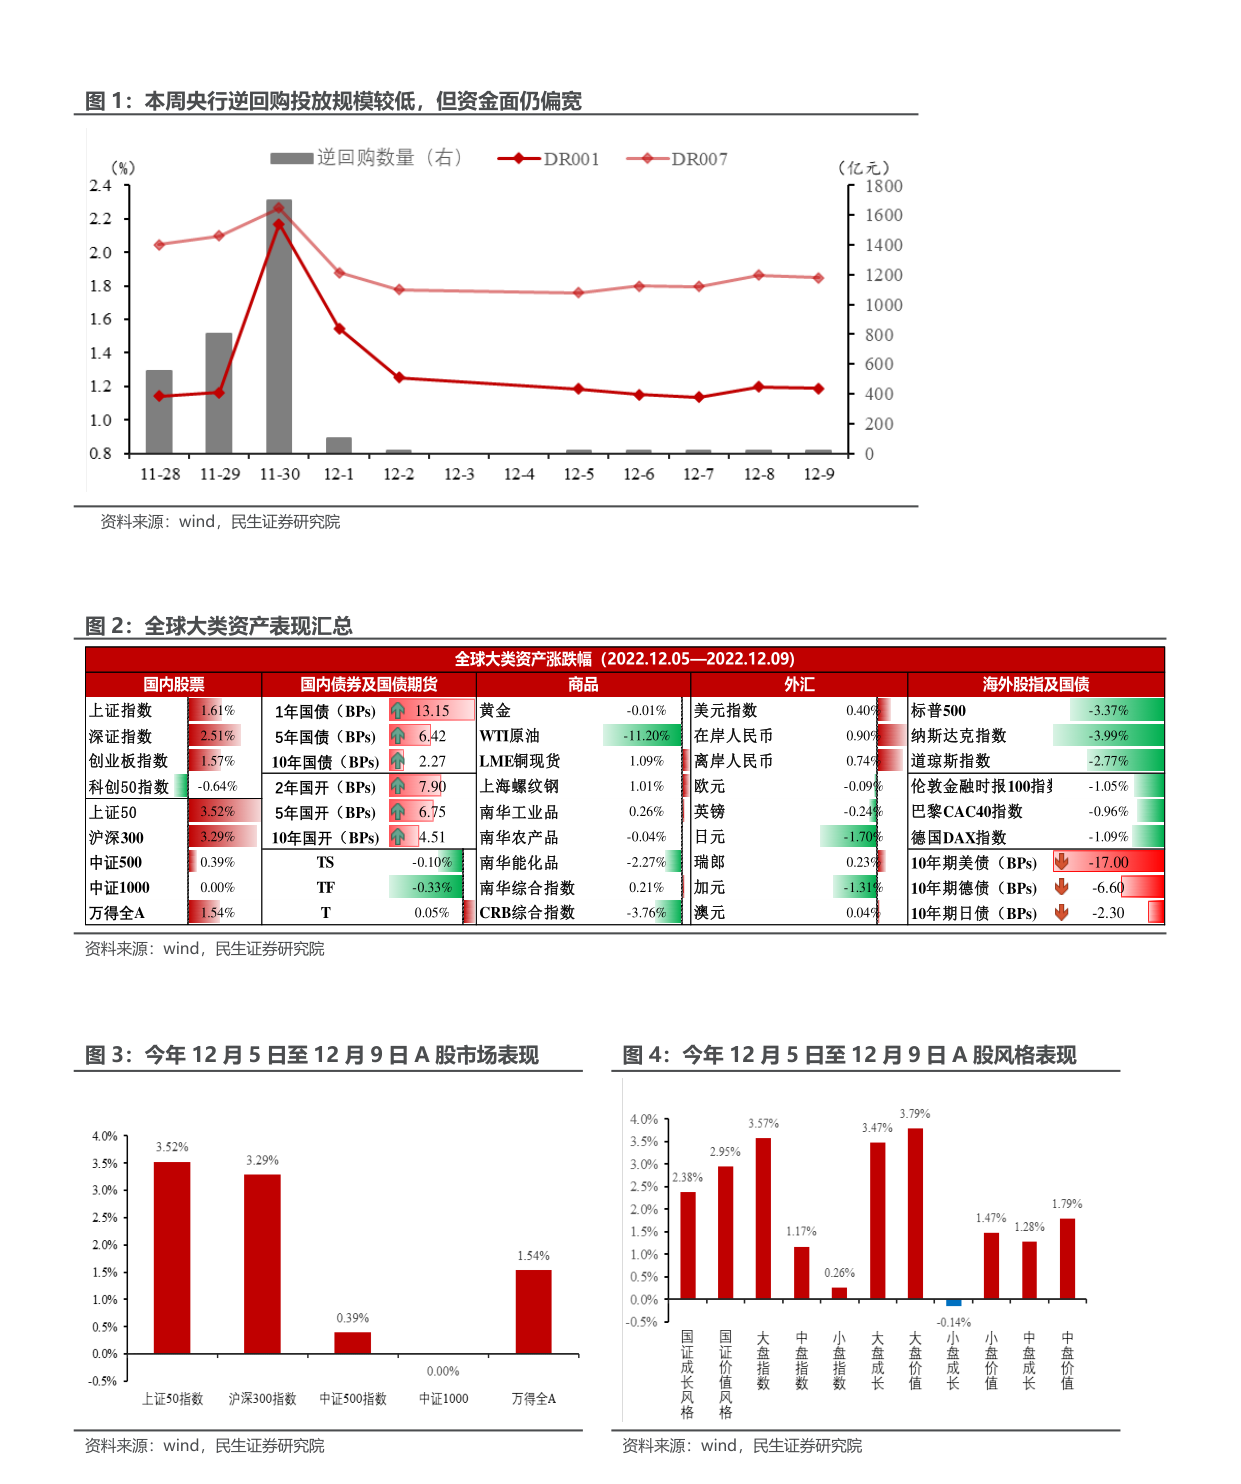
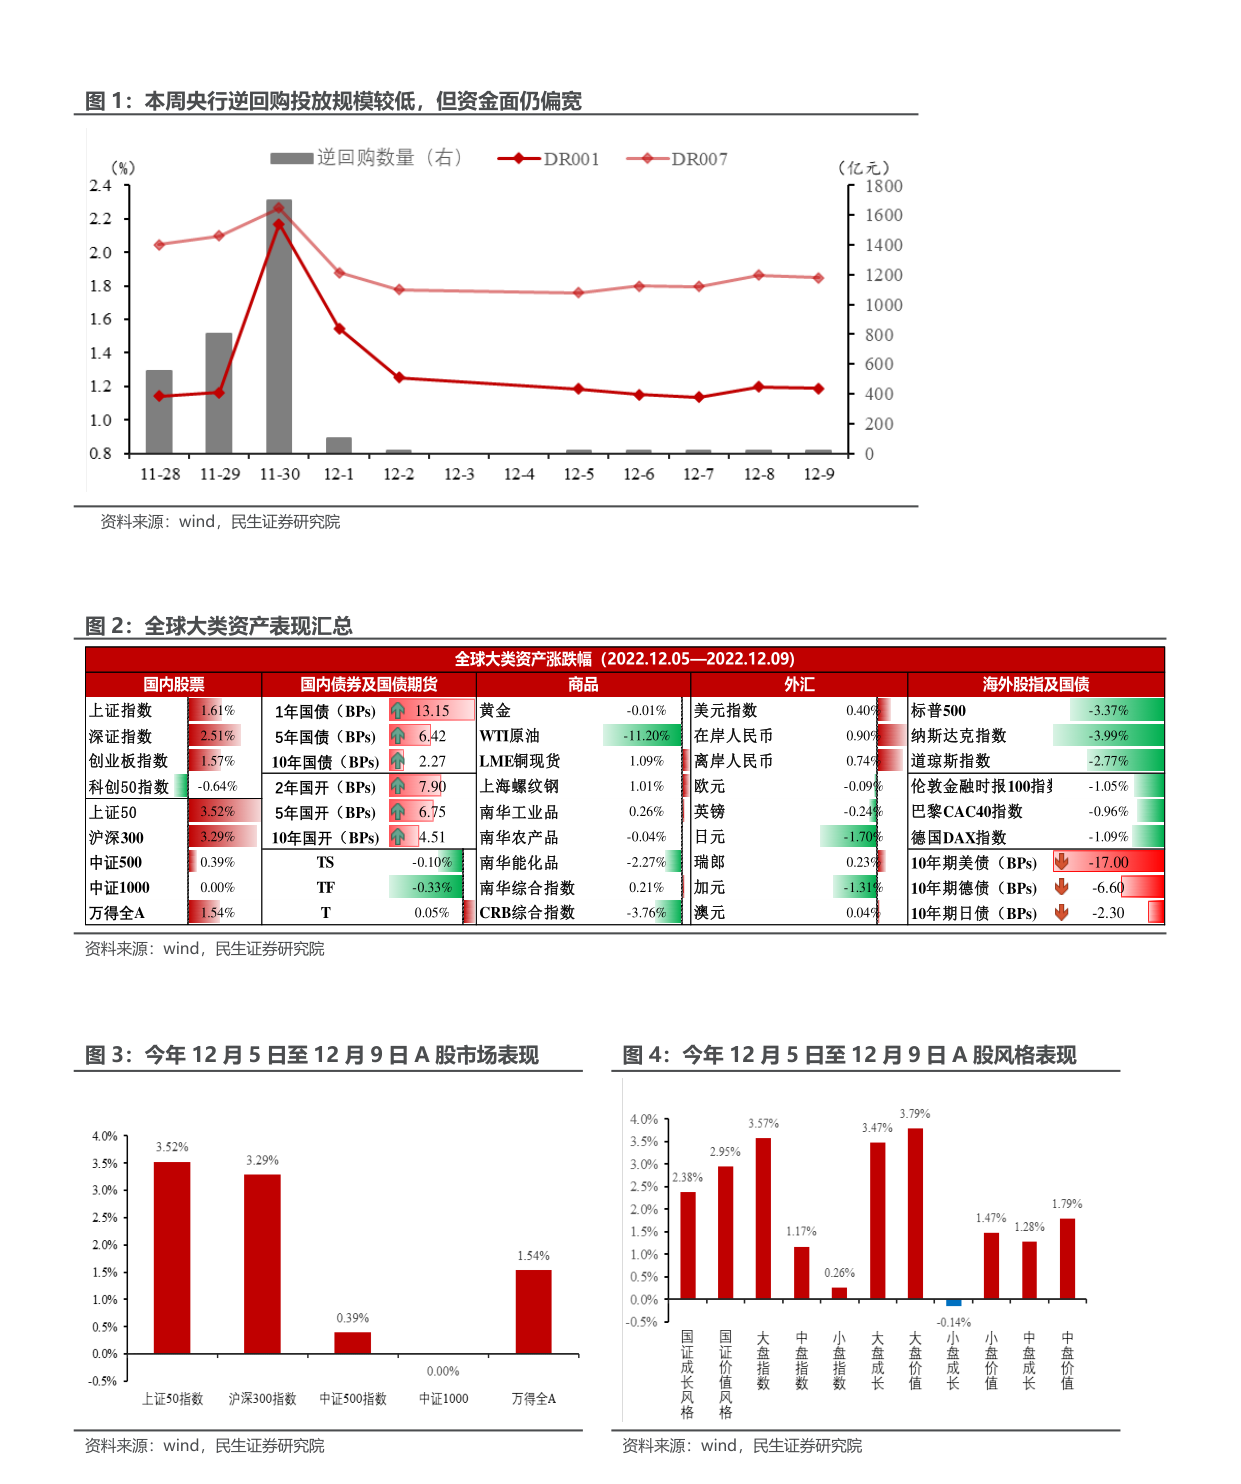

In [6]:
MODE = 'sequential'
# 可选: 'single', 'sequential', 'random', 'filter'
INDEX = 0         # 当 MODE='single' 时使用
COUNT = 2
# 当 MODE='sequential' 或 'random' 时使用
SHOW_IMAGE = True # 是否显示图片
SHOW_MODELS = True # 是否显示模型回答
QUESTION_TYPE_FILTER = "问答题"  # 当 MODE='filter' 时使用

# ============================================================================
# 执行查看
# ============================================================================

if MODE == 'single':
    # 1. 查看指定索引的问题
    if 0 <= INDEX < len(data):
        print(f"查看第 {INDEX+1} 个问题（索引: {INDEX}）\n")
        display_question(data[INDEX], show_image=SHOW_IMAGE, show_models=SHOW_MODELS)
    else:
        print(f"❌ 索引 {INDEX} 超出范围（总共 {len(data)} 个问题）")

elif MODE == 'sequential':
    # 2. 顺序查看前N个问题
    n = min(COUNT, len(data))
    for i in range(n):
        print(f"\n\n{'#'*80}")
        print(f"# 第 {i+1} 个问题（索引: {i}）")
        print(f"{'#'*80}\n")
        display_question(data[i], show_image=SHOW_IMAGE, show_models=SHOW_MODELS)

elif MODE == 'random':
    # 3. 随机查看N个问题
    n = min(COUNT, len(data))
    random_indices = random.sample(range(len(data)), n)
    print(f"随机选择的索引: {random_indices}\n")
    
    for idx, i in enumerate(random_indices, 1):
        print(f"\n\n{'#'*80}")
        print(f"# 第 {idx} 个随机问题（索引: {i}）")
        print(f"{'#'*80}\n")
        display_question(data[i], show_image=SHOW_IMAGE, show_models=SHOW_MODELS)

elif MODE == 'filter':
    # 4. 筛选特定类型的问题
    filtered_data = [item for item in data if item['question_type'] == QUESTION_TYPE_FILTER]
    print(f"找到 {len(filtered_data)} 个 '{QUESTION_TYPE_FILTER}' 类型的问题\n")
    
    if filtered_data:
        n = min(COUNT, len(filtered_data))
        for idx, item in enumerate(filtered_data[:n], 1):
            print(f"\n\n{'#'*80}")
            print(f"# 第 {idx} 个 '{QUESTION_TYPE_FILTER}'")
            print(f"{'#'*80}\n")
            display_question(item, show_image=SHOW_IMAGE, show_models=SHOW_MODELS)
    else:
        print(f"❌ 没有找到 '{QUESTION_TYPE_FILTER}' 类型的问题")

else:
    print(f"❌ 未知的查看模式: {MODE}")
    print("支持的模式: 'single', 'sequential', 'random', 'filter'")


In [7]:
# 统计问题类型分布
from collections import Counter

question_types = [item['question_type'] for item in data]
type_counts = Counter(question_types)

print("问题类型分布:")
for qtype, count in type_counts.items():
    print(f"  {qtype}: {count} 个")

print("\n图片类型分布:")
image_types = [item['image_type'] for item in data]
image_type_counts = Counter(image_types)
for itype, count in image_type_counts.items():
    print(f"  {itype}: {count} 个")

if any('classification' in item for item in data):
    print("\n分类级别分布:")
    levels = [item['classification']['level'] for item in data if 'classification' in item]
    level_counts = Counter(levels)
    for level, count in level_counts.items():
        print(f"  {level}: {count} 个")


问题类型分布:
  判断题: 24 个

图片类型分布:
  pure_image: 24 个
